In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Dropout, BatchNormalization, Activation, Embedding, multiply, ZeroPadding2D, UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import random
import shutil

In [2]:
dataset_dir = 'dataset'
subset_dir = 'subset'
zip_file = 'fruits.zip'

# Create the dataset directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Download the dataset from Kaggle
!kaggle datasets download -d yashchoudhary2oo5/fruits-100x100 -p {dataset_dir} --unzip

# Set up paths
train_dir = os.path.join(dataset_dir, 'fruits-360-100x100-main/Training')
test_dir = os.path.join(dataset_dir, 'fruits-360-100x100-main/Test')

# Define the subset directory
subset_train_dir = os.path.join(subset_dir, 'Training')
subset_test_dir = os.path.join(subset_dir, 'Test')

# Ensure subset directory exists
if not os.path.exists(subset_train_dir):
    os.makedirs(subset_train_dir)
if not os.path.exists(subset_test_dir):
    os.makedirs(subset_test_dir)

# Select random 10k images from the training dataset
def create_subset(original_dir, subset_dir, num_images=10000):
    for class_dir in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_dir)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            selected_images = random.sample(images, min(num_images // len(os.listdir(original_dir)), len(images)))

            subset_class_dir = os.path.join(subset_dir, class_dir)
            if not os.path.exists(subset_class_dir):
                os.makedirs(subset_class_dir)

            for image in selected_images:
                src_path = os.path.join(class_path, image)
                dst_path = os.path.join(subset_class_dir, image)
                shutil.copy(src_path, dst_path)

# Select 10,000 random images
create_subset(train_dir, subset_train_dir, num_images=10000)
create_subset(test_dir, subset_test_dir, num_images=10000)
# Define the image size and batch size
img_size = (64, 64)
batch_size = 64
img_shape = (64, 64, 3)  # Example image shape
num_classes = 10         # Example number of classes
latent_dim = 100

Dataset URL: https://www.kaggle.com/datasets/yashchoudhary2oo5/fruits-100x100
License(s): unknown
100% 400M/401M [00:20<00:00, 23.4MB/s]
100% 401M/401M [00:20<00:00, 20.7MB/s]


In [3]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
img_width, img_height = 64, 64

train_generator = datagen.flow_from_directory(subset_train_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              class_mode='categorical')

test_generator = datagen.flow_from_directory(subset_test_dir,
                                             target_size=(img_width, img_height),
                                             batch_size=batch_size,
                                             class_mode='categorical')

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

Found 9956 images belonging to 131 classes.
Found 9956 images belonging to 131 classes.


In [5]:
noise_shape = 100

#  Generator will upsample our seed using convolutional transpose layers (upsampling layers)
def generator_model():
  generator=Sequential()

  # Random noise to 4x4x512 image
  generator.add(Dense(4*4*512, input_shape=[noise_shape]))

  #  Next, add a reshape layer to the network to reshape the tensor from the
  # last layer to a tensor of a shape of (4, 4, 512):
  generator.add(Reshape([4,4,512]))
  generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                  activation='sigmoid'))
  return generator

generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         2097408   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       5

In [6]:
def discriminator_model():
  discriminator = Sequential()
  discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[64,64, 3]))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                      

In [7]:
GAN =Sequential([generator,discriminator])

discriminator.compile(optimizer='adam',loss='binary_crossentropy')

# When we train this network, we don't want to train the discriminator network,
# so make it non-trainable before we add it to the adversarial model.
discriminator.trainable = False

GAN.compile(optimizer='adam',loss='binary_crossentropy')

GAN.layers

GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         3585219   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 55361     
                                                                 
Total params: 3640580 (13.89 MB)
Trainable params: 3584323 (13.67 MB)
Non-trainable params: 56257 (219.75 KB)
_________________________________________________________________


In [8]:
loss_from_discriminator_model = []
loss_from_generator_model = []


def train(train_dir, test_dir, epochs, batch_size=128, save_interval=5):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(64, 64), batch_size=batch_size, class_mode=None)
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(64, 64), batch_size=batch_size, class_mode=None)

    total_iterations = (train_generator.samples // batch_size) * epochs
    print(f"Total iterations: {total_iterations}")

    for epoch in range(epochs):
        print(f"Currently training on Epoch {epoch + 1}")
        for i in range(train_generator.samples // batch_size):
            if i % 100 == 0:
                print(f"\tCurrently training on batch number {i} (iteration {i + epoch * (train_generator.samples // batch_size)})")

            # Train Discriminator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)

            try:
                imgs = next(train_generator)
                if len(imgs) != batch_size:
                    continue  # Skip this batch if it doesn't match the batch size
            except StopIteration:
                train_generator.reset()
                imgs = next(train_generator)
                if len(imgs) != batch_size:
                    continue

            valid = np.ones((batch_size, 1))
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(imgs, valid)

            fake = np.zeros((batch_size, 1))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid = np.ones((batch_size, 1))
            discriminator.trainable = False

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train Generator
            g_loss = GAN.train_on_batch(noise, valid)
            loss_from_discriminator_model.append(d_loss)
            loss_from_generator_model.append(g_loss)

        if epoch % save_interval == 0:
            discriminator.save(f'discriminator_epoch_{epoch + 1}.h5')
            generator.save(f'generator_epoch_{epoch + 1}.h5')

            samples = 10
            x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

            for k in range(samples):
                plt.subplot(2, 5, k + 1)
                plt.imshow(x_fake[k].reshape(64, 64, 3))
                plt.xticks([])
                plt.yticks([])
            plt.tight_layout()
            plt.show()
            print(f'Epoch: {epoch + 1},  Loss: D_real = {d_loss_real:.3f}, D_fake = {d_loss_fake:.3f},  G = {g_loss:.3f}')

    print('Training completed with all epochs')

In [9]:
def evaluate(generator, batch_size):
    total_batches = len(generator)
    d_loss_real_accum = 0
    d_loss_fake_accum = 0
    g_loss_accum = 0

    for _ in range(total_batches):
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        imgs = next(generator)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        d_loss_real = discriminator.test_on_batch(imgs, valid)
        d_loss_fake = discriminator.test_on_batch(gen_imgs, fake)
        discriminator.trainable = False
        g_loss = GAN.test_on_batch(noise, valid)
        discriminator.trainable = True

        d_loss_real_accum += d_loss_real
        d_loss_fake_accum += d_loss_fake
        g_loss_accum += g_loss

    d_loss_real_avg = d_loss_real_accum / total_batches
    d_loss_fake_avg = d_loss_fake_accum / total_batches
    g_loss_avg = g_loss_accum / total_batches

    print(f'Evaluation results - D_real: {d_loss_real_avg:.3f}, D_fake: {d_loss_fake_avg:.3f}, G: {g_loss_avg:.3f}')

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version: ", tf.__version__)

Num GPUs Available:  1
TensorFlow version:  2.15.0


Found 9956 images belonging to 131 classes.
Found 9956 images belonging to 131 classes.
Total iterations: 15400
Currently training on Epoch 1
	Currently training on batch number 0 (iteration 0)
4/4 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 383ms/step


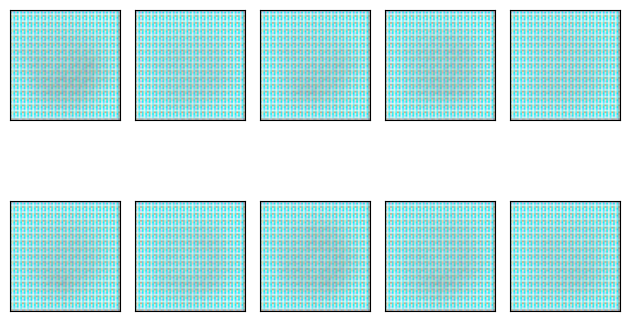

Epoch: 1,  Loss: D_real = 0.004, D_fake = 0.000,  G = 0.000
Currently training on Epoch 2
	Currently training on batch number 0 (iteration 77)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 3
	Currently training on batch number 0 (iteration 154)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 4
	Currently training on batch number 0 (iteration 231)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 5
	Currently training on batch number 0 (iteration 308)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 6
	Currently training on batch number 0 (iteration 385)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 7
	Currently training on batch number 0 (iteration 462)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 8
	Currently training on batch number 0 (iteration 539)
4/4 [==============================] - 0s 6ms/s

1/1 [==============================] - 0s 17ms/step


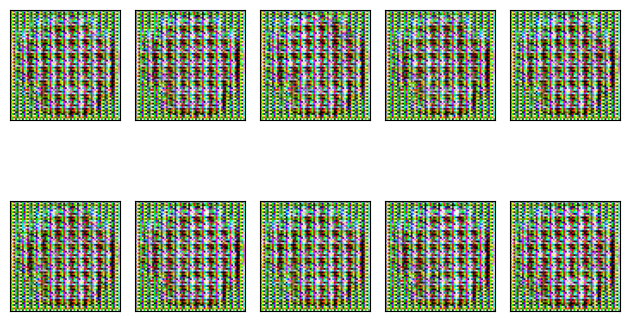

Epoch: 21,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 22
	Currently training on batch number 0 (iteration 1617)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 23
	Currently training on batch number 0 (iteration 1694)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 24
	Currently training on batch number 0 (iteration 1771)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 25
	Currently training on batch number 0 (iteration 1848)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 26
	Currently training on batch number 0 (iteration 1925)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 27
	Currently training on batch number 0 (iteration 2002)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 28
	Currently training on batch number 0 (iteration 2079)
4/4 [==========================

1/1 [==============================] - 0s 29ms/step


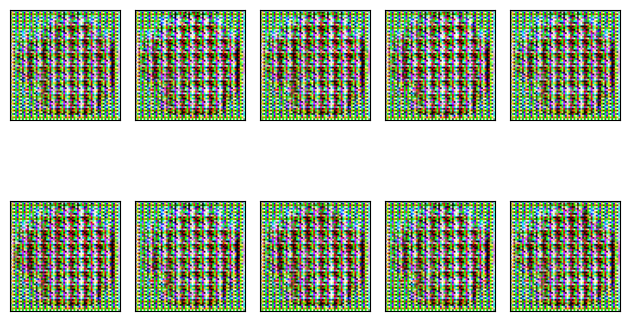

Epoch: 41,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 42
	Currently training on batch number 0 (iteration 3157)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 43
	Currently training on batch number 0 (iteration 3234)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 44
	Currently training on batch number 0 (iteration 3311)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 45
	Currently training on batch number 0 (iteration 3388)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 46
	Currently training on batch number 0 (iteration 3465)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 47
	Currently training on batch number 0 (iteration 3542)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 48
	Currently training on batch number 0 (iteration 3619)
4/4 [==========================

1/1 [==============================] - 0s 30ms/step


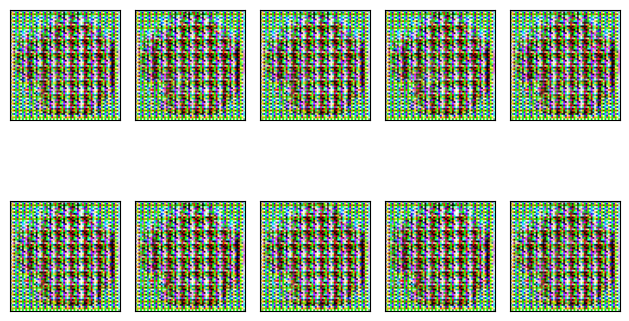

Epoch: 61,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 62
	Currently training on batch number 0 (iteration 4697)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 63
	Currently training on batch number 0 (iteration 4774)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 64
	Currently training on batch number 0 (iteration 4851)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 65
	Currently training on batch number 0 (iteration 4928)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 66
	Currently training on batch number 0 (iteration 5005)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 67
	Currently training on batch number 0 (iteration 5082)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 68
	Currently training on batch number 0 (iteration 5159)
4/4 [==========================

1/1 [==============================] - 0s 19ms/step


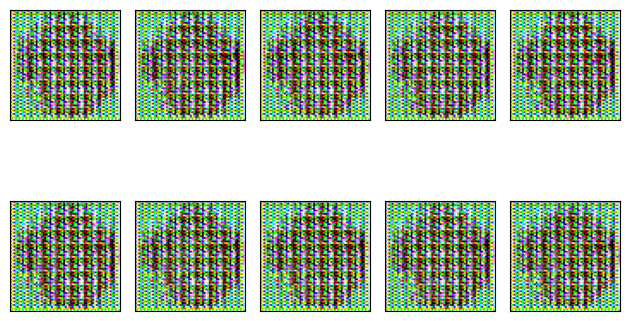

Epoch: 81,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 82
	Currently training on batch number 0 (iteration 6237)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 83
	Currently training on batch number 0 (iteration 6314)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 84
	Currently training on batch number 0 (iteration 6391)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 85
	Currently training on batch number 0 (iteration 6468)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 86
	Currently training on batch number 0 (iteration 6545)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 87
	Currently training on batch number 0 (iteration 6622)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 88
	Currently training on batch number 0 (iteration 6699)
4/4 [==========================

1/1 [==============================] - 0s 28ms/step


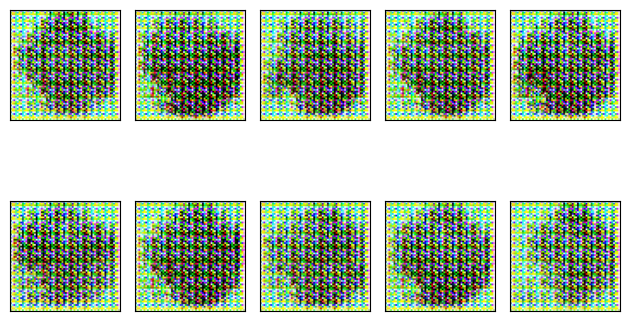

Epoch: 101,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 102
	Currently training on batch number 0 (iteration 7777)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 103
	Currently training on batch number 0 (iteration 7854)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 104
	Currently training on batch number 0 (iteration 7931)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 105
	Currently training on batch number 0 (iteration 8008)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 106
	Currently training on batch number 0 (iteration 8085)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 107
	Currently training on batch number 0 (iteration 8162)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 108
	Currently training on batch number 0 (iteration 8239)
4/4 [==================

1/1 [==============================] - 0s 19ms/step


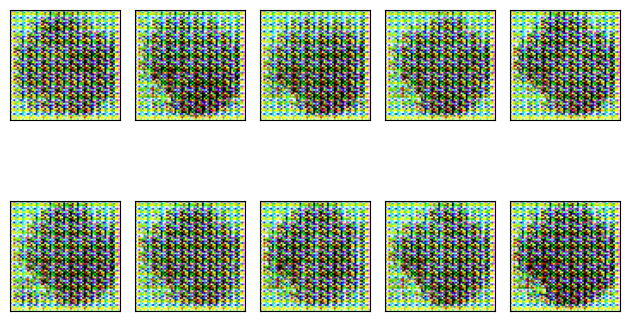

Epoch: 121,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 122
	Currently training on batch number 0 (iteration 9317)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 123
	Currently training on batch number 0 (iteration 9394)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 124
	Currently training on batch number 0 (iteration 9471)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 125
	Currently training on batch number 0 (iteration 9548)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 126
	Currently training on batch number 0 (iteration 9625)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 127
	Currently training on batch number 0 (iteration 9702)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 128
	Currently training on batch number 0 (iteration 9779)
4/4 [==================

1/1 [==============================] - 0s 17ms/step


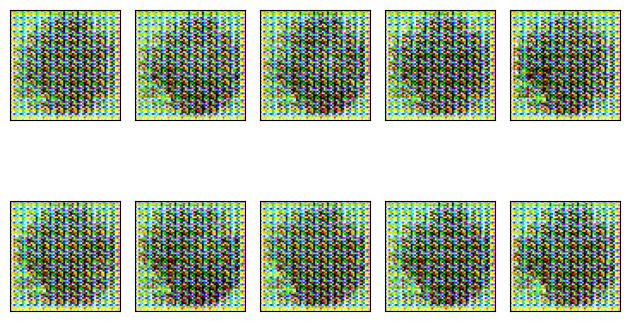

Epoch: 141,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 142
	Currently training on batch number 0 (iteration 10857)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 143
	Currently training on batch number 0 (iteration 10934)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 144
	Currently training on batch number 0 (iteration 11011)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 145
	Currently training on batch number 0 (iteration 11088)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 146
	Currently training on batch number 0 (iteration 11165)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 147
	Currently training on batch number 0 (iteration 11242)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 148
	Currently training on batch number 0 (iteration 11319)
4/4 [===========

1/1 [==============================] - 0s 27ms/step


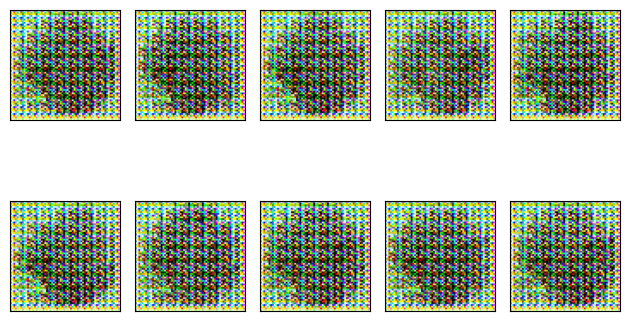

Epoch: 161,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 162
	Currently training on batch number 0 (iteration 12397)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 163
	Currently training on batch number 0 (iteration 12474)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 164
	Currently training on batch number 0 (iteration 12551)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 165
	Currently training on batch number 0 (iteration 12628)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 166
	Currently training on batch number 0 (iteration 12705)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 167
	Currently training on batch number 0 (iteration 12782)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 168
	Currently training on batch number 0 (iteration 12859)
4/4 [===========

1/1 [==============================] - 0s 35ms/step


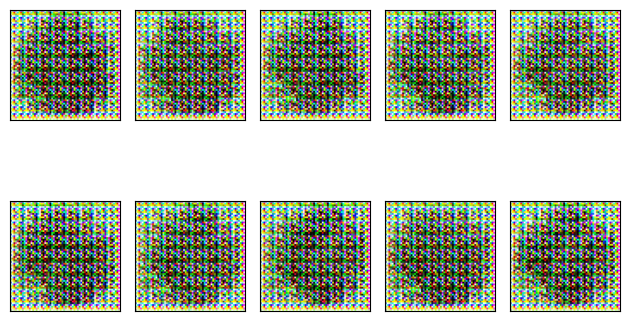

Epoch: 181,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently training on Epoch 182
	Currently training on batch number 0 (iteration 13937)
4/4 [==============================] - 0s 6ms/step
Currently training on Epoch 183
	Currently training on batch number 0 (iteration 14014)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 184
	Currently training on batch number 0 (iteration 14091)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 185
	Currently training on batch number 0 (iteration 14168)
4/4 [==============================] - 0s 4ms/step
Currently training on Epoch 186
	Currently training on batch number 0 (iteration 14245)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 187
	Currently training on batch number 0 (iteration 14322)
4/4 [==============================] - 0s 5ms/step
Currently training on Epoch 188
	Currently training on batch number 0 (iteration 14399)
4/4 [===========

In [11]:
train(train_dir=subset_train_dir, test_dir=subset_test_dir, epochs=201, batch_size=128, save_interval=20)

4/4 [==============================] - 0s 7ms/step


<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

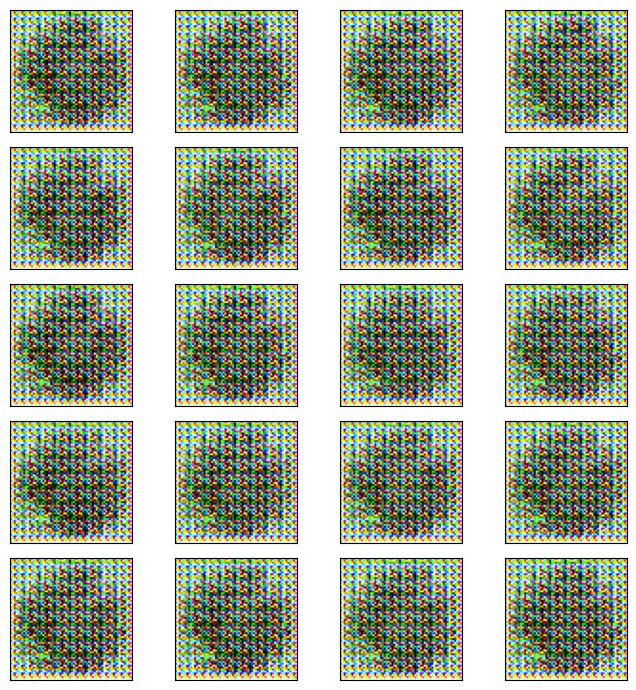

In [12]:
for i in range(5):
  plt.figure(figsize=(7,7))
for k in range(20):
          noise=np.random.uniform(-1,1,size=[100,noise_shape])
          im=generator.predict(noise)
          plt.subplot(5, 4, k+1)
          plt.imshow(im[k].reshape(64,64,3))
          plt.xticks([])
          plt.yticks([])

plt.tight_layout()
plt.show()